# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# State Level Production Model

In [2]:
state_data = pd.read_csv('../Data/merged_state_final.csv')
state_data.head()

,Location,Employment_2020,Employment_2021,Employment_2022,Inc_Per_Cap_2020,Inc_Per_Cap_2021,Inc_Per_CAp_2022,Life_Exp_2020,Life_Exp_2019,Life_Exp_2018,...,"Yes, 50 or more people",all_causes_2020,all_causes_2021,all_causes_2022,covid_2020,covid_2021,covid_2022,Covid_pop_perce_2020,Covid_pop_perce_2021,Covid_pop_perce_2022
0,Alabama,2671005,2769464,2869931,45887,50059,50916,73.2,75.2,75.1,...,1.00,9021,13018,6246,6337,9771,3933,0.001261,0.001945,0.000783
1,Alaska,430840,443047,457687,61898,65662,68635,76.6,77.7,78.0,...,0.00,545,1429,686,213,804,275,0.000290,0.001096,0.000375
2,Arizona,3920033,4086802,4287595,52133,56420,58442,76.3,78.8,78.7,...,2.89,13186,17961,8835,8603,13536,5849,0.001203,0.001893,0.000818
3,Arkansas,1639829,1686444,1755536,47147,51636,52618,73.8,75.7,75.6,...,1.00,4992,6908,3854,3691,5333,2593,0.001226,0.001771,0.000861
4,California,23154091,23934549,25300974,70061,76991,77036,79.0,80.9,80.8,...,1.18,41279,60680,36786,29962,48834,21158,0.000758,0.001235,0.000535


In [3]:
X1 = state_data.drop(columns=['Location', 'Mask_Mandate','Exc_deaths_2017', 'Exc_deaths_2018','Exc_deaths_2019',
                              'Exc_deaths_2020', 'Exc_deaths_2021','Exc_deaths_2022',
                      'all_causes_2020', 'all_causes_2021', 'all_causes_2022', 'covid_2020',
                      'covid_2021', 'covid_2022', 'Covid_pop_perce_2020', 'Covid_pop_perce_2021',
                     'Covid_pop_perce_2022'])
y1 = state_data[['covid_2020', 'covid_2021', 'covid_2022']]

In [4]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=42)
state_poly = PolynomialFeatures()
X1_train_poly = state_poly.fit_transform(X1_train)
X1_test_poly = state_poly.transform(X1_test)

state_sc = StandardScaler()
X1_train_polysc = state_sc.fit_transform(X1_train_poly)
X1_test_polysc = state_sc.transform(X1_test_poly)

In [5]:
%%time
fgrad = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 1, n_estimators = 200)
fmulti = MultiOutputRegressor(fgrad)
fmulti.fit(X1_train_polysc, y1_train)

fmulti.score(X1_train_polysc, y1_train), fmulti.score(X1_test_polysc, y1_test)

CPU times: user 7.21 s, sys: 11.9 ms, total: 7.22 s
Wall time: 7.3 s


(0.9999918872830208, 0.9118772225048173)

In [6]:
test_data = pd.read_csv('../Data/Test_Data/state_test_data.csv')
test_x = test_data.drop(columns=['Location', 'Change', 'Mask_Mandate'])
test_xpoly = state_poly.transform(test_x)
test_x_polysc = state_sc.transform(test_xpoly)

In [7]:
y_pred = pd.DataFrame(fmulti.predict(test_x_polysc))
results = test_data[['Location', 'Change']]
results = pd.merge(results, y_pred, left_index=True, right_index=True)
results.rename(columns={0: 'covid_deaths_2020', 1: 'covid_deaths_2021', 2: 'covid_deaths_2022'}, inplace=True)
results.head(10)

,Location,Change,covid_deaths_2020,covid_deaths_2021,covid_deaths_2022
0,Mississippi,Original,4906.910915,5872.654510,3055.783445
1,Mississippi,Mask,4906.910915,5876.984386,3055.783445
2,Mississippi,Visit a friend,4906.910915,5872.654510,3055.783445
3,Mississippi,Dose_pop_2021,4906.910915,5872.654510,3055.783445
4,Mississippi,Wearing mask,4906.910915,5872.654510,3050.447947
5,Mississippi,All Changes,4906.910915,5876.984386,3050.447947
6,West Virginia,Original,1348.695136,3834.794277,2217.510485
7,West Virginia,Mask,1348.695136,3830.464401,2217.510485
8,West Virginia,Visit a friend,1482.877408,3853.630124,2217.510485
9,West Virginia,Dose_pop_2021,1348.695136,3834.794277,2217.510485


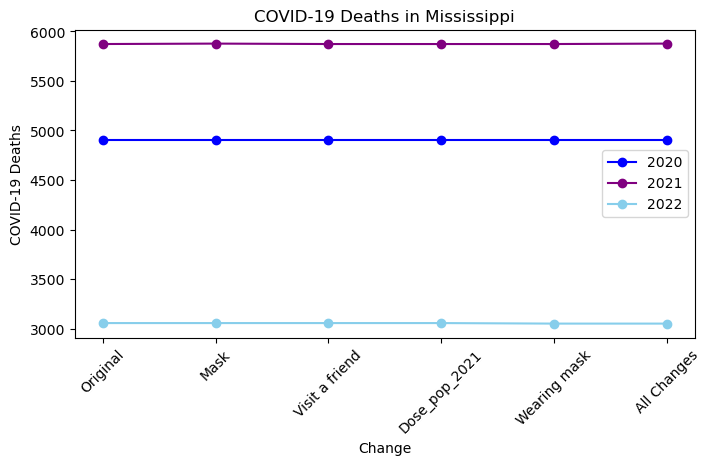

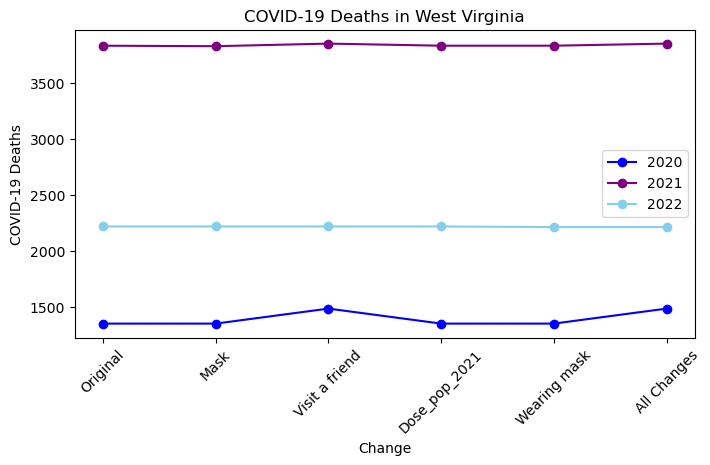

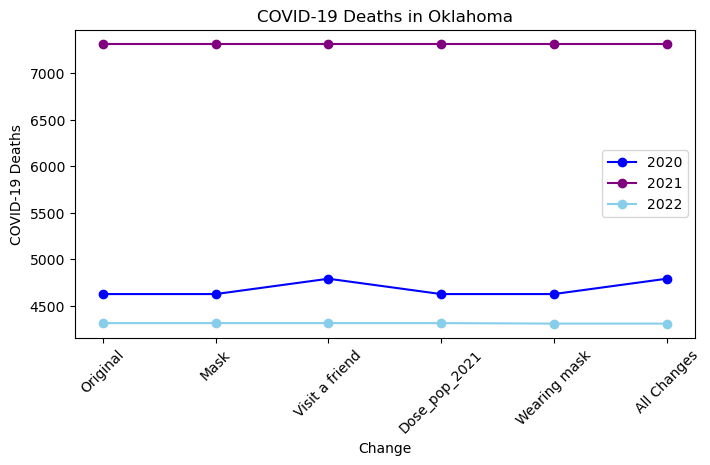

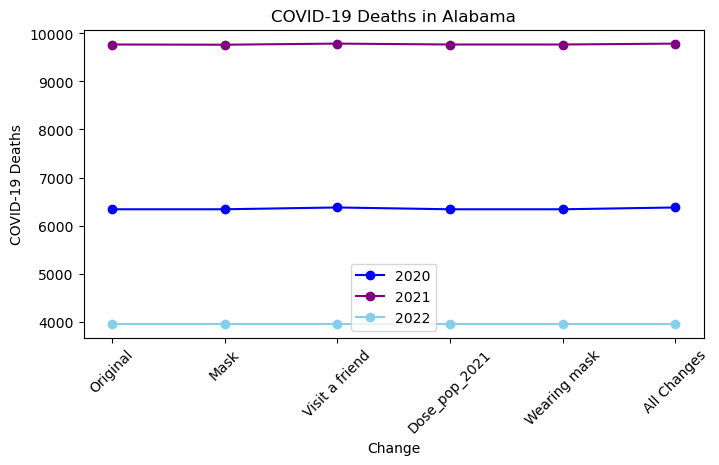

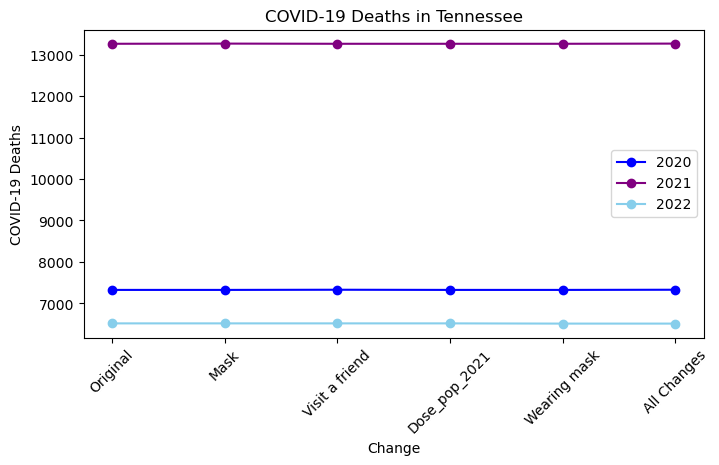

In [20]:
colors = ['blue', 'purple', 'skyblue']
unique_states = results["Location"].unique()
for state in unique_states:
    state_df = results[results["Location"] == state]
    fig, ax = plt.subplots(figsize=(8, 4))
    
    for i, year in enumerate(["covid_deaths_2020", "covid_deaths_2021", "covid_deaths_2022"]):
        y_values = state_df[year]
        x_values = state_df["Change"]
        label = f"{year[-4:]}"  
        color = colors[i]

        
        ax.plot(x_values, y_values, label=label, color=color, marker='o')

    ax.set_xlabel("Change")
    ax.set_ylabel("COVID-19 Deaths")
    ax.set_title(f"COVID-19 Deaths in {state}")
    ax.legend()
    plt.xticks(rotation=45)

## State Conclusion

To conclude when looking at the State level data, we can see that we were able to create a black box model that is able to successfully acounts for a round 90% variability of Covid deaths. However, this model contains a wide variety of features and each only have a small impact on the predicted deaths. Therefore when we are manually adjusted the selected parameters to test are model above we are only seeing very little to now changes.

# County Level Production Model